In [1]:
import pandas as pd
ndcp = pd.read_csv('NDCP2022.csv')

In [2]:
ndcp.head()

,STATE_NAME,STATE_ABBREVIATION,COUNTY_NAME,COUNTY_FIPS_CODE,STUDYYEAR,EMR_16,FEMR_16,MEMR_16,EMR_20to64,FEMR_20to64,...,iFEMP_SERVICE_STATE,iEMP_SALES_STATE,iMEMP_SALES_STATE,iFEMP_SALES_STATE,iEMP_N_STATE,iMEMP_N_STATE,iFEMP_N_STATE,iEMP_P_STATE,iMEMP_P_STATE,iFEMP_P_STATE
0,Alabama,AL,Autauga County,1001,2008,61.5,56.1,67.3,71.4,66.3,...,1,1,1,1,1,1,1,1,1,1
1,Alabama,AL,Autauga County,1001,2009,60.6,54.8,67.0,72.5,66.9,...,1,1,1,1,1,1,1,1,1,1
2,Alabama,AL,Autauga County,1001,2010,60.4,54.9,66.4,72.3,67.4,...,1,1,1,1,1,1,1,1,1,1
3,Alabama,AL,Autauga County,1001,2011,58.7,52.4,65.6,71.0,64.9,...,1,1,1,1,1,1,1,1,1,1
4,Alabama,AL,Autauga County,1001,2012,57.7,52.2,63.8,70.7,65.1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
ndcp.shape

(48308, 370)

In [4]:
import re
ndcp = ndcp.rename(columns=lambda x: x.strip().upper())

ndcp_key = pd.read_csv('technical-report-key.csv')
ndcp_key = ndcp_key.rename(columns=lambda x: x.strip())
for col in ndcp_key.columns:
    if ndcp_key[col].dtype == "object":
        ndcp_key[col] = ndcp_key[col].apply(lambda x: re.sub('[\u2012\u2013\u2014]', '-',str(x)))
        ndcp_key[col] = ndcp_key[col].str.replace('-', ' - ')
        ndcp_key[col] = ndcp_key[col].str.replace('\xa0', ' ', regex=False) # embedded new-lines
        ndcp_key[col] = ndcp_key[col].str.replace('  ', ' ', regex=False)
        ndcp_key[col] = ndcp_key[col].apply(lambda x: re.sub('(\d)\s*-\s*(\d)', r'\1-\2',str(x)))
        ndcp_key[col] = ndcp_key[col].str.strip()
ndcp_key['Variable Name'] = ndcp_key['Variable Name'].str.upper()
ndcp_key['Variable Name'] = ndcp_key['Variable Name'].apply(lambda x: re.sub('\s', '',str(x)))
ndcp_key['Variable Name'] = ndcp_key['Variable Name'].replace({'IURN_20TO64':'IUNR_20TO64'})
ndcp_dict = dict(zip(ndcp_key['Variable Name'], ndcp_key['Variable Label']))
ndcp_key.head()

,Variable Name,Variable Label,Variable Description,Variable Format,Report Table ID
0,_75C12TO17,75th Percentile Price of Center - Based Care -...,75th percentile price charged for Center - Bas...,Numeric,nan
1,_75C18TO23,75th Percentile Price of Center - Based Care -...,75th percentile price charged for Center - Bas...,Numeric,nan
2,_75C24TO29,75th Percentile Price of Center - Based Care -...,75th percentile price charged for Center - Bas...,Numeric,nan
3,_75C30TO35,75th Percentile Price of Center - Based Care -...,75th percentile price charged for Center - Bas...,Numeric,nan
4,_75C36TO41,75th Percentile Price of Center - Based Care -...,75th percentile price charged for Center - Bas...,Numeric,nan


In [5]:
file_columns = ndcp.columns.sort_values()
missing = []
for column in file_columns:
    if column in ndcp_dict:
        continue
    missing.append(column)
if len(missing):
    print("Missing from report: ",missing)
else:
    print("Every column in the file is also in the report.")
file_dict = dict(zip(file_columns,file_columns))
missing = []
for column in ndcp_dict.keys():
    if column in file_dict:
        continue
    missing.append(column)
if len(missing):
    print("Missing from file: ",missing)
else:
    print("Every column in the report is also in the file.")
print("The file has {} columns. The report has {} columns.".format(len(file_columns),len(ndcp_dict.keys())))

Missing from report:  ['IEMP_M_STATE']
Every column in the report is also in the file.
The file has 370 columns. The report has 369 columns.


In [6]:
def described_data (columns):
    upper_columns = [column.upper() for column in columns]
    data = ndcp[upper_columns]
    #for column in columns:
    #    print(column+": "+ndcp_dict[column.upper()])
    return data

In [7]:
non_imputations = []
categories = ['STATE_ABBREVIATION','COUNTY_NAME','STUDYYEAR']
ignore = [
'STATE_NAME',
'COUNTY_FIPS_CODE',
'IEMP_M_STATE'
] + categories
for column in ndcp.columns:
    if column in ignore:
        continue
    if re.match('imput',ndcp_dict[column].lower()):
        continue
    non_imputations.append(column)
data = described_data(non_imputations)
matrix = data.corr()
data = described_data(non_imputations+categories)

In [8]:
def search(search,exclude=False):
    for column in data.columns:
        full = ndcp_dict[column]
        if search.lower() in full.lower():
            print("{}|{}".format(column,full))    

In [23]:
search('abbreviation')
#FEMR_20TO64|Female Employment Rate (20-64)


STATE_ABBREVIATION|State abbreviation


KeyError: 'numerator'

In [10]:
cost_config = {
    'MCUNDER6': ['MC','Median Center Cost Under 6'],
    '_75CUNDER6':['_75C','75th Percentile Center Cost Under 6'],
    'MFCCUNDER6':['MFCC','Median Family Cost Under 6'],
    '_75FCCUNDER6':['_75FCC','75th Percentile Family Cost Under 6'],
}
temp = data.copy()
#temp = data[['STATE_ABBREVIATION','COUNTY_NAME','STUDYYEAR']].copy()
for key, value in cost_config.items():
    prefix = value[0]
    label = value[1]
    temp[key] = (data[prefix+'INFANT']+data[prefix+'TODDLER']+data[prefix+'PRESCHOOL'])/3
    ndcp_dict[key] = label
for key, value in cost_config.items():
    temp[key+'PERC']=temp[key]*52/data['MFI_2022'] # 52 weeks full-time
    ndcp_dict[key+'PERC'] = label+' Percent'

age_config = {
    'H_UNDER6_': 'Households with Children Under 6',
    'H_6TO17_':'Households with Children 6-17',
    }
for age,label in age_config.items():
    temp[age+'PERC'] = (data[age+'BOTHWORK']+data[age+'FWORK']+data[age+'MWORK']+data[age+'SINGLEM'])/data['HOUSEHOLDS']
    ndcp_dict[age+'PERC'] = 'Percent '+label

temp['HOUSEHOLD_SIZE'] = data['TOTALPOP']/data['HOUSEHOLDS']
ndcp_dict['HOUSEHOLD_SIZE'] = 'Average people per household'

data = temp

In [25]:
data['female impact'] = data['FLFPR_20TO64_6TO17']-data['FLFPR_20TO64_UNDER6']

print("Avg. Cost per Child of Family Income",data['MCUNDER6PERC'].mean())
print("Avg. Impact to Female Employment",data['female impact'].mean())
print("Avg. Cost per Child per Week",data['MCUNDER6'].mean())

texas = data[data['STATE_ABBREVIATION']=='TX']
print("Texas Avg. Cost per Child of Family Income",texas['MCUNDER6PERC'].mean())
print("Texas Avg. Impact to Female Employment",texas['female impact'].mean())
print("Texas Avg. Cost per Child per Week",texas['MCUNDER6'].mean())

Avg. Cost per Child of Family Income 0.0987560076374108
Avg. Impact to Female Employment 9.143901631199801
Avg. Cost per Child per Week 140.63074830507676
['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY' 'PR']
Texas Avg. Cost per Child of Family Income 0.09012458584177005
Texas Avg. Impact to Female Employment 12.882782152230972
Texas Avg. Cost per Child per Week 121.52220378702663


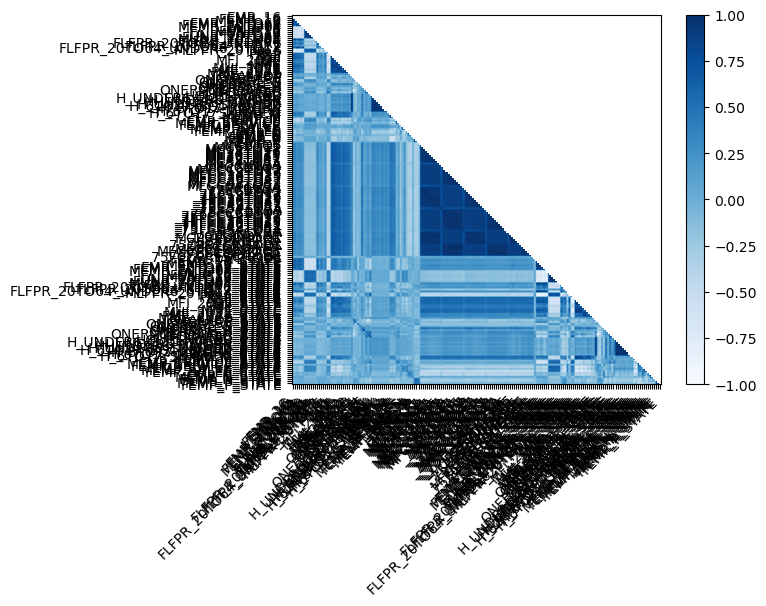

In [149]:
# Adapted from https://www.geeksforgeeks.org/create-a-correlation-matrix-using-python/
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sklearn import datasets
import pandas as pd

# Use green for > 0.5 correlation and red for < 0.5
colors_list = ['red','lightgray','lightgray','green']

# Create a colormap from the list of colors
cmap = colors.ListedColormap(colors_list)

# Mask the duplicated upper triangle and the diagonal
mask = np.triu(np.ones_like(matrix, dtype=bool))
masked_matrix = np.ma.masked_array(matrix, mask)

# plot the masked correlation matrix
plt.imshow(masked_matrix, vmin=-1, vmax=1, cmap="Blues")

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Make the figure full screen
plt.rcParams['figure.figsize'] = [24, 24]

# Display the plot
plt.show()

In [150]:
# Set a threshold for strong correlations
threshold = 0.5
correlations = []
seen = {}
# Iterate through the correlation matrix and filter based on the threshold
for column in matrix.columns:
    for index in matrix.index:
        if index != column and abs(matrix.loc[index, column]) > threshold:
            seen_key = ''.join(sorted([index,column]))
            if seen_key in seen:
                continue
            seen[seen_key]=1
            correlation = matrix.loc[index, column]
            correlations.append({
                'correlation':correlation,
                'index':index,
                'column':column,
            })

cors = sorted(correlations, key=lambda d: d['correlation'])
print("There are {} correlations over {}. For example:".format(len(cors),threshold))
for cor in cors[123:128]:
    print("{:.5f} {} -> {}".format(cor['correlation'],ndcp_dict[cor['index']],ndcp_dict[cor['column']]))

There are 3459 correlations over 0.5. For example:
-0.63903 Male Median Earnings -> Poverty Rate (all people)
-0.63758 State Level Male Labor Force Participation Rate (20-64) -> Poverty Rate (all people)
-0.63466 State Level Median Earnings -> State Level Unemployment Rate (16+)
-0.63407 State Level Median Earnings -> State Level Poverty Rate (all people)
-0.63379 State Level Female Employment Rate (20-64) -> Poverty Rate (all families)


Some uninteresting correlations here are that childcare costs for the different brackets rise and fall together, that employment and unemployment rates rise and fall together, that wages and costs rise and fall together, and others.

But, from reviewing all these correlations, here are some I want to investigate further:


* -0.60497 State Level Female Labor Force Participation Rate (20-64) with Children 6-17 only -> State Level Female Unemployment Rate (16+)
* 0.50099 Median Price of Center - Based Care - Toddler -> Civilian Employed Pop. (16+) Management, business, science, and arts occupations
* 0.51337 Civilian Employed Pop. (16+) Management, business, science, and arts occupations -> Median Earnings - 2022 Adjusted

There seems to be a correlation between "Management, business, science, and arts occupations" and median income as well as one between employment in "Management, business, science, and arts occupations" and child care costs. I need to look at this closer to see if it is just the costs and wages correlation or if an argument can be made that reducing child care costs would increase "Management, business, science, and arts occupations" participation and therefore drive up median wages (and taxes).

In [151]:
def cor_search(search,exclude=False):
    print("Searching correlations for '{}'...:\n".format(search))
    for cor in cors:
        index = ndcp_dict[cor['index']]
        column = ndcp_dict[cor['column']]
        if search.lower() in index.lower():
            if exclude and exclude.lower() in column.lower():
                continue
            print("{:.5f} {} -> {}\n{}->{} ".format(cor['correlation'],index,column,cor['index'],cor['column']))    

In [152]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Here is a function to plot a scatter plot with density,
# adapted from https://stackoverflow.com/a/20107592.
def density_scatter(df,x_name,y_name):
    x,y = df[x_name].to_numpy(),df[y_name].to_numpy()
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    fig, ax = plt.subplots()
    cax = ax.scatter(x, y, c=z, s=50, edgecolor=None)
    plt.title(x_name +" vs. "+y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

In [153]:
#cor_search('Management, business, science, and arts occupations','State')

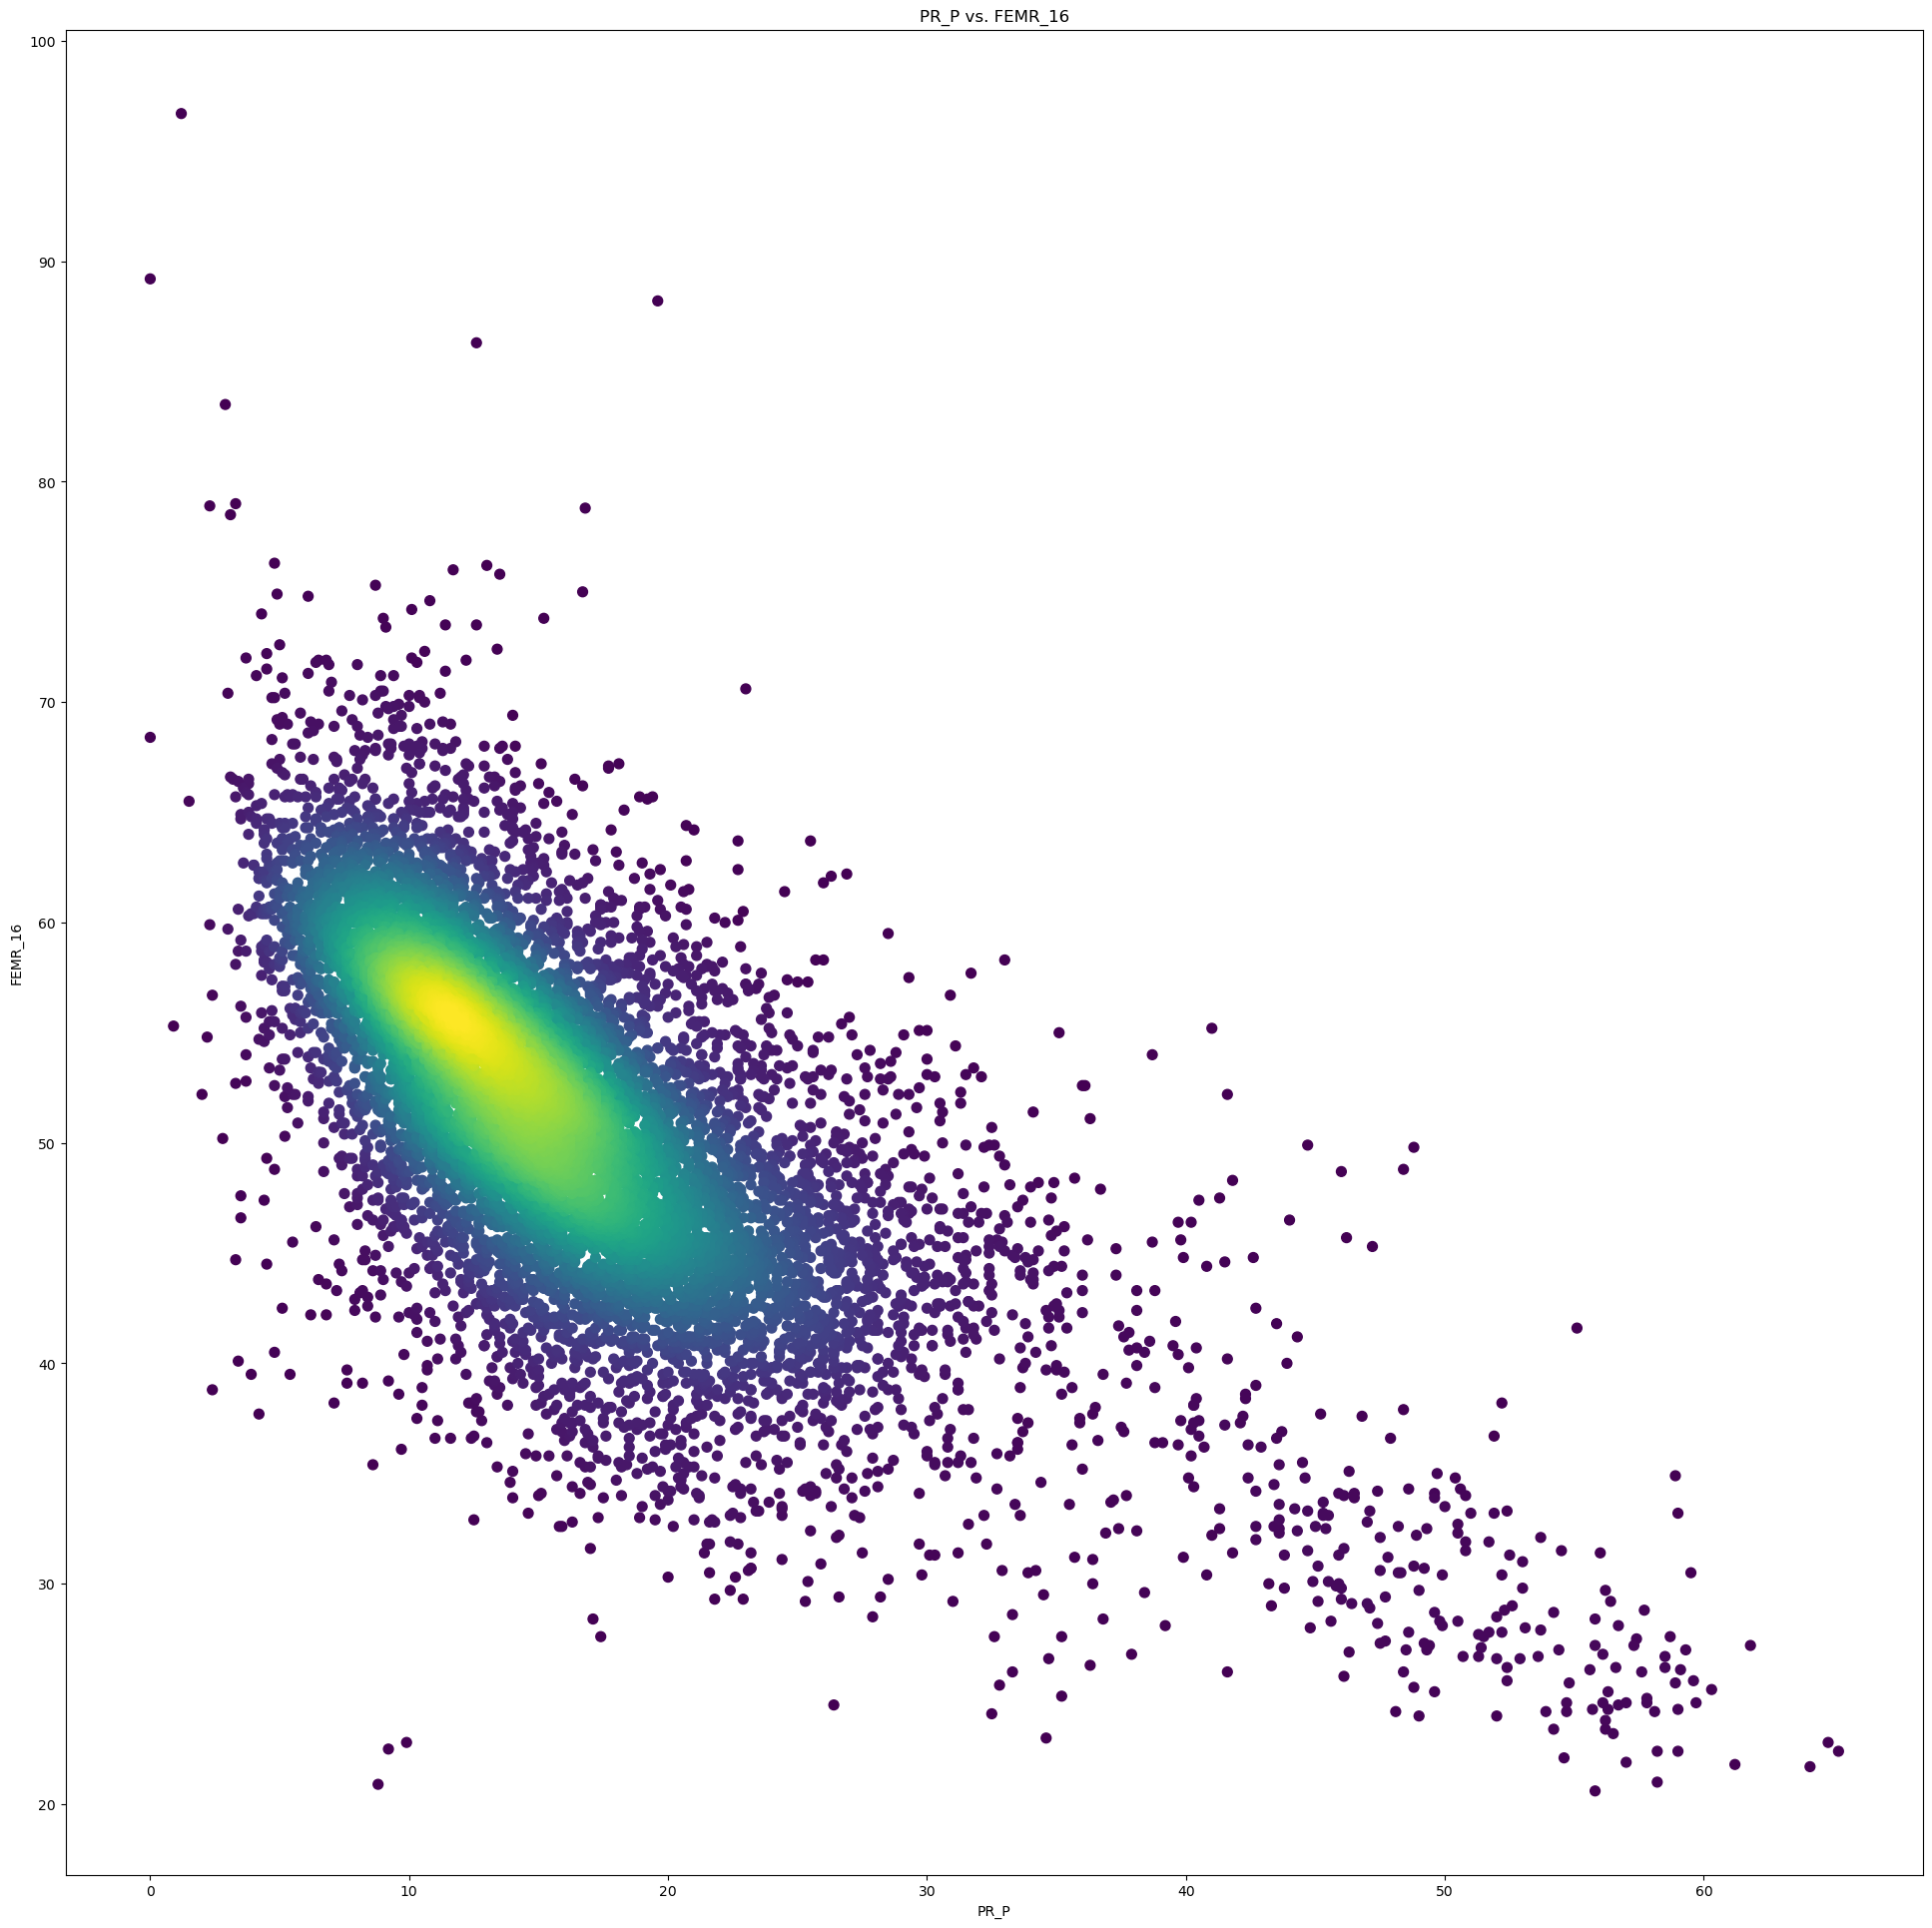

In [154]:
x = 'PR_P'
y = 'FEMR_16'
scatter = data[[x,y]]
scatter=scatter.dropna()
density_scatter(scatter.sample(n=10000),x,y)

In [155]:
# cor_search('Poverty Rate (all people)','State')
# -0.72227 Poverty Rate (all people) -> Employment Rate (20-64)
# PR_P->EMR_20TO64 
# -0.69734 Poverty Rate (all people) -> Female Employment Rate (16+)
# PR_P->FEMR_16 
# -0.63074 Poverty Rate (all people) -> Male Employment Rate (16+)
# PR_P->MEMR_16 

# cor_search('Participation Rate (20-64) with Children','State')
# 0.66990 Female Labor Force Participation Rate (20-64) with Children 6-17 only -> Female Labor Force Participation Rate (20-64)
# FLFPR_20TO64_6TO17->FLFPR_20TO64 

#cor_search('Median Price of Center','Price of ')
# 0.68750 Median Price of Center - Based Care - Preschool -> Median family income
# MCPRESCHOOL->MFI 
# 0.50618 Median Price of Center - Based Care - Preschool -> Civilian Employed Pop. (16+) Management, business, science, and arts occupations
# MCPRESCHOOL->EMP_M 



In [213]:
def get_columns(search):
    return list(filter(lambda s: search.lower() in ndcp_dict[s].lower(), list(data.columns)))

def reset_X_y(target):
    #columns = get_columns('Price of')
    columns = ['MCTODDLER']
    columns = columns + get_columns('Labor Force')
    columns = columns + get_columns('Households with Children')
    
    columns = columns + get_columns('Civilian Employed Pop.')
    columns = list(filter(lambda s: "male civilian employed" not in ndcp_dict[s].lower(), columns))
    
    columns = columns + ['MFI','FME','MME','PR_P']

    #columns = columns + get_columns('Race')
    
    columns = list(filter(lambda s: "imputations" not in ndcp_dict[s].lower(), columns))
    columns = list(filter(lambda s: "state level" not in ndcp_dict[s].lower(), columns))
    independent = list(columns)
    #for item in independent:
    #    print(ndcp_dict[item]+"\n")
    independent.remove(target)
    df = data[data['STATE_ABBREVIATION']=='AL'].copy()
    df = df[independent+[target]]
    df = df.dropna()
    X = df[independent]
    y = df[target]  
    return X,y

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

def model_metrics(target,independent,sample=None):
    df = data[independent+[target]].copy()
    df = df.dropna()
    X = df[independent]
    y = df[target]

    if sample:
        s=X.sample(n=1)
        print(s)
        
    # Split data into training and testing sets (optional but recommended)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 3. Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    if sample:
        print('orig',model.predict(s))
        s[sample]=70
        print(70,model.predict(s))
        s[sample]=90
        print(90,model.predict(s))
        s[sample]=95
        print(95,model.predict(s))
    
    def print_model_metrics(test,pred):
        mae = metrics.mean_absolute_error(test, pred)
        mse = metrics.mean_squared_error(test, pred)
        rmse = np.sqrt(mse) # or mse**(0.5)
        r2 = metrics.r2_score(test, pred)
        print("R-Squared:", r2)
        print("Root Mean Squared Error (RMSE):", rmse)
        print("Mean Absolue Error (MAE): ",mae)
    
    print_model_metrics(y_test,predictions)

    coefficients = model.coef_
    full_independent = [item+' '+ndcp_dict.get(item, item) for item in independent]
    coef_df = pd.DataFrame({'Feature': full_independent, 'Coefficient': coefficients})
    coef_df['Positive'] = coef_df['Coefficient'] > 0
    coef_df['Coefficient'] =coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    print(coef_df)

In [191]:
independent = ['H_6TO17_FWORK', 'MFI', 'H_6TO17_BOTHWORK', 'H_6TO17_MWORK', 'EMP_SERVICE', 'FME', 'H_6TO17_SINGLEM', 'FLFPR_20TO64', 'H_UNDER6_MWORK', 'MME']
model_metrics(target,independent)

34058    64.9
Name: FLFPR_20TO64, dtype: float64
       H_6TO17_FWORK    MFI  H_6TO17_BOTHWORK  H_6TO17_MWORK  EMP_SERVICE  \
34058             62  45907               161             17         28.6   

         FME  H_6TO17_SINGLEM  FLFPR_20TO64  H_UNDER6_MWORK    MME  
34058  20093            126.0          64.9               0  15253  
orig [134.76415943]
70 [134.82711805]
90 [135.07401462]
95 [135.13573876]
R-Squared: 0.5470035254376662
Root Mean Squared Error (RMSE): 31.832794190688634
Mean Absolue Error (MAE):  23.366765202769564
                                             Feature  Coefficient  Positive
4  EMP_SERVICE Civilian Employed Pop. (16+) Servi...     2.038765      True
7  FLFPR_20TO64 Female Labor Force Participation ...     0.012345      True
8  H_UNDER6_MWORK Households with Children Under ...     0.008747      True
3  H_6TO17_MWORK Households with Children 6-17 wi...     0.007324      True
0  H_6TO17_FWORK Households with Children 6-17 wi...     0.002731     False
1

In [108]:
from sklearn.feature_selection import RFE

X,y = reset_X_y()

from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier processing
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Absolute correlation values
correlation_matrix = X_scaled_df.corr().abs()

def drop_highly_correlated_features(corr_matrix, threshold=0.9):
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return to_drop

high_corr_features = drop_highly_correlated_features(correlation_matrix)

# Drop them from scaled data
X_reduced = X_scaled_df.drop(columns=high_corr_features)

top_10_variances = X_reduced.var().sort_values(ascending=False).head(10)
top_10_features = top_10_variances.index.tolist()

print("Top 10 selected features:", top_10_features)
model_metrics(top_10_features)

Top 10 selected features: ['ONERACE_H', 'ONERACE_I_STATE', 'ONERACE_H_STATE', 'MEMP_SALES_STATE', 'FME_STATE', 'ONERACE_A_STATE', 'EMP_SALES_STATE', 'FLFPR_20TO64_UNDER6_STATE', 'FEMP_SERVICE_STATE', 'ONERACE_I']
R-Squared: 0.2598331572290159
Root Mean Squared Error (RMSE): 7.061963408998715
Mean Absolue Error (MAE):  5.117362778570164


In [214]:
target='MCTODDLER'
X,y = reset_X_y(target)

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Scale your features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Fit Lasso with cross-validation
lasso = LassoCV(cv=5, max_iter=5000,random_state=42)
lasso.fit(X_scaled, y)

# 3. Extract selected features
selected_mask = lasso.coef_ != 0
selected_features = X.columns[selected_mask]

# 4. Sort by absolute coefficient value and pick top 10
top_10 = pd.Series(lasso.coef_, index=X.columns)[selected_mask].abs().sort_values(ascending=False).head(10).index.tolist()

print("Top 10 features selected by Lasso:", top_10)
model_metrics(target,top_10)

Top 10 features selected by Lasso: ['MME', 'FME', 'MFI', 'PR_P', 'H_UNDER6_BOTHWORK', 'EMP_M', 'FLFPR_20TO64_UNDER6_6TO17', 'MLFPR_20TO64', 'FLFPR_20TO64_UNDER6', 'FLFPR_20TO64_6TO17']
R-Squared: 0.5036308930319395
Root Mean Squared Error (RMSE): 33.32189736364397
Mean Absolue Error (MAE):  24.57609389049964
                                             Feature  Coefficient  Positive
3                     PR_P Poverty Rate (all people)     0.401351      True
5  EMP_M Civilian Employed Pop. (16+) Management,...     0.139907      True
7  MLFPR_20TO64 Male Labor Force Participation Ra...     0.109888     False
6  FLFPR_20TO64_UNDER6_6TO17 Female Labor Force P...     0.065931     False
8  FLFPR_20TO64_UNDER6 Female Labor Force Partici...     0.019741     False
9  FLFPR_20TO64_6TO17 Female Labor Force Particip...     0.009542     False
2                           MFI Median family income     0.001913      True
1                         FME Female Median Earnings     0.001263      True
0     

In [127]:
X,y = reset_X_y('PR_P') 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestRegressor(n_jobs=-1,n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Rank features
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_10_rf = importances.sort_values(ascending=False).head(10).index.tolist()

print("Top 10 features by Random Forest:", top_10_rf)
model_metrics(top_10_rf)

Top 10 features by Random Forest: ['MFI', 'MLFPR_20TO64', 'MME', 'H_UNDER6_SINGLEM', 'FLFPR_20TO64_UNDER6_6TO17_STATE', 'FLFPR_20TO64', 'H_6TO17_SINGLEM', 'MEMP_N', 'EMP_N', 'FLFPR_20TO64_6TO17_STATE']
R-Squared: 0.6823475720190837
Root Mean Squared Error (RMSE): 4.623330743741631
Mean Absolue Error (MAE):  3.319848220768903
                                             Feature  Coefficient  Positive
5  FLFPR_20TO64 Female Labor Force Participation ...     0.343913     False
8  EMP_N Civilian Employed Pop. (16+) Natural res...     0.195438     False
4  FLFPR_20TO64_UNDER6_6TO17_STATE State Level Fe...     0.109195     False
7  MEMP_N Male Civilian Employed Pop. (16+) Natur...     0.079809     False
1  MLFPR_20TO64 Male Labor Force Participation Ra...     0.067099     False
9  FLFPR_20TO64_6TO17_STATE State Level Female La...     0.040832      True
3  H_UNDER6_SINGLEM Households with Children Unde...     0.000284     False
2                           MME Male Median Earnings     0.000192

In [146]:
def get_columns(search):
    return list(filter(lambda s: search.lower() in ndcp_dict[s].lower(), list(data.columns)))

def reset_X_y(target):
    columns = []
    columns = columns + get_columns('Civilian Employed')
    columns = list(filter(lambda s: re.match('^e',s.lower()),columns))
    #columns = columns + list(data.columns)
    #print(columns)
    ignore = columns + ['MFI_2022','FME_2022',
        'UNR_20TO64',
        'H_6TO17_PERC',
        'H_UNDER6_PERC',
        'FLFPR_20TO64_6TO17',
        'FLFPR_20TO64_UNDER6',
        'FLFPR_20TO64',
                         'HOUSEHOLDS',
        'MFI_2022',
'FME_2022',
'EMP_SERVICE',
'HOUSEHOLDS',
'FEMP_N',
'FEMP_SALES',
'H_6TO17_PERC',
'UNR_20TO64',
'EMP_N',
'FLFPR_20TO64_6TO17',
    ]
    #print("Cost: ",columns)
    #columns = columns+get_columns('Under 6')
    
    #columns = columns + get_columns('Households with Children')
    #columns = columns + get_columns('Employment Rate')
    
    columns = columns + get_columns('Civilian Employed Pop.')
    columns = list(filter(lambda s: "male civilian employed" not in ndcp_dict[s].lower(), columns))
    
    columns = columns + ['MFI','HOUSEHOLDS','UNR_16','H_6TO17_PERC']

#    columns = columns + get_columns('Race')
    
    columns = list(filter(lambda s: s not in categories, columns))
    columns = list(filter(lambda s: "cost" not in ndcp_dict[s].lower(), columns))
    columns = list(filter(lambda s: "price of" not in ndcp_dict[s].lower(), columns))
    columns = list(filter(lambda s: "race" not in ndcp_dict[s].lower(), columns))    
    columns = list(filter(lambda s: "imputations" not in ndcp_dict[s].lower(), columns))
    columns = list(filter(lambda s: "state level" not in ndcp_dict[s].lower(), columns))


    #columns = list(filter(lambda s: "civilian employed" not in ndcp_dict[s].lower(), columns))
    
    independent = list(columns)
    #for item in independent:
    #    print(ndcp_dict[item]+"\n")
    to_drop = [
        "FEMR_16",
        "MEMR_16",
        "FUNR_16",
        "MUNR_16",
        "PR_F",
        "MHI",
        "ME",
        "MHI_2022",
        "FME",
        "MME",
        "ME",
        "H_UNDER6_BOTHWORK",
        "H_UNDER6_FWORK",
        "H_UNDER6_MWORK",
        "H_UNDER6_SINGLEM",
        "H_6TO17_BOTHWORK",
        "H_6TO17_FWORK",
        "H_6TO17_MWORK",
        "H_6TO17_SINGLEM",
        "FUNR_20TO64",
        "MUNR_20TO64",
        "MEMR_20TO64",
        "FLFPR_20TO64",
        "MLFPR_20TO64",
        #"MFI",
        "MME_2022",
        "MEMP_M",
        "MEMP_N",
        "MEMP_P",
        "MEMP_SERVICE",
        "MEMP_SALES",
        "TOTALPOP",
        "EMR_16",
        "UNR_16",      
    ] + [target]
    for column in to_drop:
        independent = [ x for x in independent if x != column ]
    independent = list(dict.fromkeys(independent))  # removes duplicates, preserves order        
    df = data.copy()
    df = df[independent+[target]]
    df = df.dropna()
    X = df[independent]
    y = df[target]
    return independent,X,y

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import numpy as np

def model_metrics(target,independent,sample=None):
    df = data.copy()
    df = df[~df['STATE_ABBREVIATION'].isin(['AK', 'HI', 'PR'])]
    df = df[independent+[target]]
    df = df.dropna()

    X = df[independent]
    print(X.shape,len(independent))
    
    y = df[target]

    if sample:
        s=X.sample(n=1)
        print(s)
        
    # Split data into training and testing sets (optional but recommended)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # 3. Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    if sample:
        print('orig',model.predict(s))
        s[sample]=70
        print(70,model.predict(s))
        s[sample]=90
        print(90,model.predict(s))
        s[sample]=95
        print(95,model.predict(s))
    
    def print_model_metrics(test, pred, num_predictors):
        from sklearn import metrics
        import numpy as np
    
        mae = metrics.mean_absolute_error(test, pred)
        mse = metrics.mean_squared_error(test, pred)
        rmse = np.sqrt(mse)
        r2 = metrics.r2_score(test, pred)
    
        n = len(test)  # number of observations
        p = num_predictors  # number of predictors (features)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
        print("R-Squared:", r2)
        print("Adjusted R-Squared:", adjusted_r2)
        print("Root Mean Squared Error (RMSE):", rmse)
        print("Mean Absolute Error (MAE):", mae)

    
    print_model_metrics(y_test,predictions,len(independent))

    coefficients = model.coef_
    full_independent = [item+' '+ndcp_dict.get(item, item) for item in independent]
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)  # Should match df[independent].columns
    print(X_scaled_df.shape)  # Should clarify the mismatch    
    coef_df = pd.DataFrame({'Feature': full_independent, 'Column':independent,'Coefficient': coefficients})
    coef_df['Positive'] = coef_df['Coefficient'] > 0
    coef_df['Coefficient'] =coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    print(coef_df[['Feature','Coefficient','Positive']].head(10))
    return list(coef_df['Column'].head(10))

target='MCUNDER6'.upper()
independent,X,y = reset_X_y(target)
print(ndcp_dict[target])
top_ten_simple = model_metrics(target,independent)
model_metrics(target,top_ten_simple)

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Scale your features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Fit Lasso with cross-validation
lasso = LassoCV(cv=5, max_iter=100000,random_state=42)
lasso.fit(X_scaled, y)

# 3. Extract selected features
selected_mask = lasso.coef_ != 0
selected_features = X.columns[selected_mask]

# 4. Sort by absolute coefficient value and pick top 10
top_10 = pd.Series(lasso.coef_, index=X.columns)[selected_mask].abs().sort_values(ascending=False).head(10).index.tolist()

print("Top 10 features selected by Lasso:", top_10)
model_metrics(target,top_10)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Use your selected top 10 features
X_top10_scaled = X_scaled_df[top_10]

# View the first few rows
X_top10_scaled.head()

Median Center Cost Under 6
(35257, 8) 8
R-Squared: 0.5301561945775557
Adjusted R-Squared: 0.529622508585311
Root Mean Squared Error (RMSE): 32.08337680999944
Mean Absolute Error (MAE): 23.774043139737383
(35257, 8)
                                             Feature  Coefficient  Positive
5                           MFI Median family income    31.322507      True
0  EMP_M Civilian Employed Pop. (16+) Management,...    16.479877     False
4  EMP_P Civilian Employed Pop. (16+) Production,...    15.738873     False
3  EMP_N Civilian Employed Pop. (16+) Natural res...    13.849940     False
2  EMP_SALES Civilian Employed Pop. (16+) Sales a...     9.171941     False
6                    HOUSEHOLDS Number of Households     8.305114      True
7  H_6TO17_PERC Percent Households with Children ...     2.911146     False
1  EMP_SERVICE Civilian Employed Pop. (16+) Servi...     1.887960     False
(35257, 8) 8
R-Squared: 0.5301561945775557
Adjusted R-Squared: 0.529622508585311
Root Mean Squared Er

,MFI,HOUSEHOLDS,EMP_SERVICE,EMP_N,H_6TO17_PERC,EMP_M,EMP_P
0,-0.043121,-0.178951,-0.220520,0.084896,1.250912,-0.623473,-0.516622
1,0.085493,-0.179642,-0.577832,-0.220056,1.696881,-0.311137,-0.376020
2,0.133043,-0.168012,-0.275491,-0.290430,1.613266,-0.340883,-0.534198
3,0.216973,-0.165735,-0.467890,-0.501551,1.576295,-0.058293,-0.305718
4,0.287743,-0.166255,-0.495376,-0.900334,1.549568,0.075565,-0.305718


In [161]:
#possible = ['MFI','MFI_2022', 'FME_2022', 'HOUSEHOLDS', 'FEMP_SALES', 'UNR_20TO64', 'FEMP_N', 'EMP_SERVICE', 'MEMP_SERVICE', 'EMP_N', 'H_6TO17_PERC']
#for column in possible:
    #print("\n\n",column)
    #model_metrics(target,[column])

In [163]:
#corr_matrix = X.corr().abs()
#high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#collinear_pairs = [(col1, col2) for col1 in high_corr.columns for col2 in high_corr.index if high_corr.loc[col2, col1] > 0.9]
#collinear_pairs

In [164]:
data[predictors].isnull().sum()


MFI                   0
FME                   0
HOUSEHOLDS            0
EMP_SERVICE           0
FEMP_SALES            0
FEMP_N                0
UNR_20TO64            0
EMP_N                 0
H_6TO17_PERC          1
FLFPR_20TO64_6TO17    0
dtype: int64

In [165]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

predictors = ['MFI', 'FME', 'HOUSEHOLDS', 'EMP_SERVICE', 'FEMP_SALES', 'FEMP_N', 'UNR_20TO64', 'EMP_N', 'H_6TO17_PERC', 'FLFPR_20TO64_6TO17']
target = 'MCUNDER6'

df_clean = data.dropna(subset=predictors)


df_known = df_clean[df_clean[target].notnull()]
df_unknown = df_clean[df_clean[target].isnull()]

X_train = df_known[predictors]
y_train = df_known[target]
model = LinearRegression()
model.fit(X_train, y_train)

X_unknown = df_unknown[predictors]
df_clean.loc[df_clean[target].isnull(), target] = model.predict(X_unknown)
temp = df_clean.copy()
temp[target+'_PERC']=temp[target]*52/data['MFI'] # 52 weeks full-time

from sklearn.preprocessing import MinMaxScaler

temp['MCUNDER6_IMPACT'] = temp['MCUNDER6_PERC']*temp['H_UNDER6_PERC']
scaler = MinMaxScaler(feature_range=(0, 100))  # Set custom range
temp['MCUNDER6_IMPACT_SCALED'] = scaler.fit_transform(temp[['MCUNDER6_IMPACT']])

df_clean = temp
df_clean.to_csv('ndcp_imputed.csv')
